In [225]:
from ml_utils import *
from sklearn.metrics import mean_absolute_error
import numpy as np

In [226]:
train_features = pd.read_csv('dengue_features_train.csv')
train_labels = pd.read_csv('dengue_labels_train.csv')
test_features = pd.read_csv('dengue_features_test.csv')
pks = ['city', 'year', 'weekofyear']

In [227]:
def window_mean(data, feature, size):
    data[feature + '_window_' + str(size)] = data[feature].rolling(size).mean()
    return data

In [228]:
train_features['month'] = np.ceil(train_features.weekofyear/4.5).map(int)

train_features = window_mean(train_features, 'reanalysis_specific_humidity_g_per_kg', 2)
train_features = window_mean(train_features, 'reanalysis_specific_humidity_g_per_kg', 4)
train_features = window_mean(train_features, 'reanalysis_dew_point_temp_k', 2)
train_features = window_mean(train_features, 'reanalysis_dew_point_temp_k', 4)
train_features = window_mean(train_features, 'station_min_temp_c', 2)
train_features = window_mean(train_features, 'station_min_temp_c', 4)
train_features = window_mean(train_features, 'station_avg_temp_c', 2)
train_features = window_mean(train_features, 'station_avg_temp_c', 4)

test_features['month'] = np.ceil(test_features.weekofyear/4.5).map(int)
test_features = window_mean(test_features, 'reanalysis_specific_humidity_g_per_kg', 2)
test_features = window_mean(test_features, 'reanalysis_specific_humidity_g_per_kg', 4)
test_features = window_mean(test_features, 'reanalysis_dew_point_temp_k', 2)
test_features = window_mean(test_features, 'reanalysis_dew_point_temp_k', 4)
test_features = window_mean(test_features, 'station_min_temp_c', 2)
test_features = window_mean(test_features, 'station_min_temp_c', 4)
test_features = window_mean(test_features, 'station_avg_temp_c', 2)
test_features = window_mean(test_features, 'station_avg_temp_c', 4)

In [229]:
train_features['total_cases_lag1'] = train_labels.total_cases.shift(1)

In [230]:
features = {
    "sj": [
        'month',
        'weekofyear',
        'reanalysis_specific_humidity_g_per_kg',
        'reanalysis_dew_point_temp_k',
        'station_min_temp_c',
        'station_avg_temp_c',
        'reanalysis_specific_humidity_g_per_kg_window_2',
        'reanalysis_dew_point_temp_k_window_2',
        'station_min_temp_c_window_2',
        'station_avg_temp_c_window_2',
        'reanalysis_specific_humidity_g_per_kg_window_4',
        'reanalysis_dew_point_temp_k_window_4',
        'station_min_temp_c_window_4',
        'station_avg_temp_c_window_4',
        'total_cases_lag1'
    ],
    "iq": [
        'month',
        'weekofyear',
        'reanalysis_specific_humidity_g_per_kg',
        'reanalysis_dew_point_temp_k',
        'station_min_temp_c',
        'station_avg_temp_c',
        'reanalysis_specific_humidity_g_per_kg_window_2',
        'reanalysis_dew_point_temp_k_window_2',
        'station_min_temp_c_window_2',
        'station_avg_temp_c_window_2',
        'reanalysis_specific_humidity_g_per_kg_window_4',
        'reanalysis_dew_point_temp_k_window_4',
        'station_min_temp_c_window_4',
        'station_avg_temp_c_window_4',
        'total_cases_lag1'
    ]
}

cat_features = ['weekofyear', 'month']
grid_params = {
    "sj":{
        'iterations': [300],
        'learning_rate': [0.05],
        'depth': [3],
        'l2_leaf_reg': [9]
    },
    "iq":{
        'iterations': [1000],
        'learning_rate': [0.1],
        'depth': [3],
        'l2_leaf_reg': [1]
    }
}

pks = ['city', 'year', 'weekofyear']

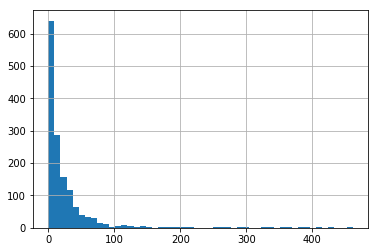

In [231]:
train_labels.total_cases.hist(bins = 50)

In [232]:
train_city('sj', train_features, train_labels, features, cat_features, grid_params, grid_search = False)
train_city('iq', train_features, train_labels, features, cat_features, grid_params, grid_search = False)

sj
0:	learn: 61.0701731	test: 33.3684173	best: 33.3684173 (0)	total: 45.7ms	remaining: 13.7s
100:	learn: 33.7975857	test: 20.5462360	best: 20.5462360 (100)	total: 2.76s	remaining: 5.44s
200:	learn: 20.6027383	test: 14.6222323	best: 14.6222323 (200)	total: 5.43s	remaining: 2.68s
299:	learn: 14.6261917	test: 11.8729384	best: 11.8729384 (299)	total: 8.01s	remaining: 0us

bestTest = 11.8729384
bestIteration = 299

          Train       Test
RMSE  14.931534  11.872938
                                        Feature Id  Importances
0                                 total_cases_lag1    81.430712
1                                            month     4.240171
2                      station_min_temp_c_window_4     1.794581
3   reanalysis_specific_humidity_g_per_kg_window_2     1.590320
4   reanalysis_specific_humidity_g_per_kg_window_4     1.496541
5            reanalysis_specific_humidity_g_per_kg     1.409635
6                      reanalysis_dew_point_temp_k     1.339241
7                   

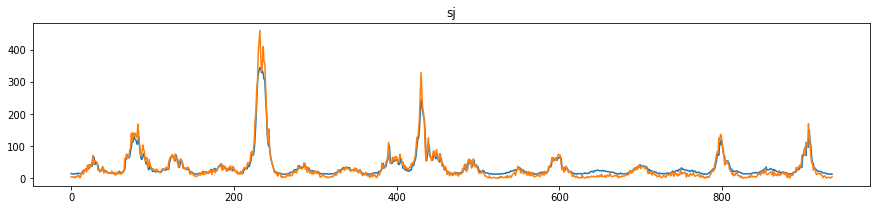

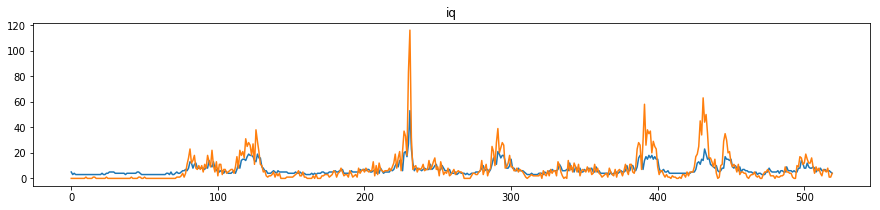

In [233]:
cities = train_features.city.unique()
train_result = pd.DataFrame()
for c in cities:
    p = predict_city(c, train_features, features, pks)
    #p.total_cases = np.exp(p.total_cases)
    p.total_cases.plot(figsize=(15,3), title = c)
    train_labels[train_labels.city == c].reset_index(drop = True).total_cases.plot(figsize=(15,3))
    train_result = train_result.append(p)
    plt.show()

In [234]:
def predict_city_lag(city, train_labels, test_features, features, pks):    
    city_test = test_features[test_features.city == city].reset_index(drop = True).copy()    
    city_test['total_cases_lag1'] = np.zeros(len(city_test))
    city_test['total_cases'] = np.zeros(len(city_test))
    
    city_train = train_labels[train_labels.city == city].reset_index(drop = True).copy()
    city_test.loc[0, 'total_cases'] = city_train.total_cases.tail(1).values[0]

    model = CatBoostRegressor()
    model.load_model(city)
    
    for i in range(0, len(city_test)):
        city_test_features = city_test[city_test.index == i].copy()
        city_test_features = city_test_features[features[city]]
        p = model.predict(city_test_features)
        city_test.loc[i, 'total_cases'] = round(p[0])
        if(i < len(city_test) - 1):
            city_test.loc[i + 1, 'total_cases_lag1'] = p[0]
    
    city_test.total_cases.plot(figsize=(15,3))
    
    city_test = city_test[pks + ['total_cases']]
    return city_test

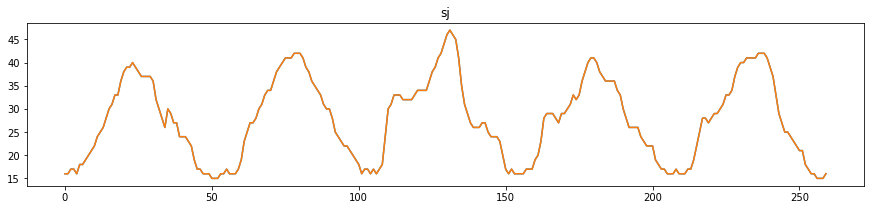

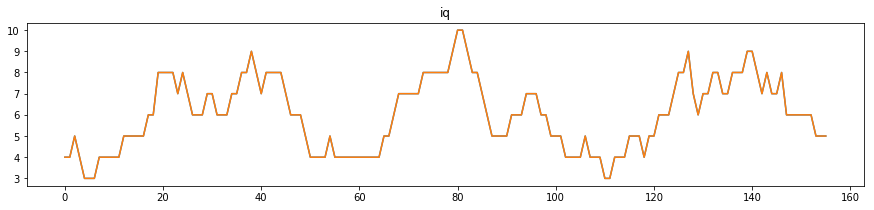

In [235]:
result = pd.DataFrame()
for c in cities:
    p = predict_city_lag(c, train_labels, test_features, features, pks)
    p.total_cases.plot(figsize=(15,3), title = c)
    result = result.append(p)
    plt.show()

In [236]:
result.total_cases = result.total_cases.map(round)

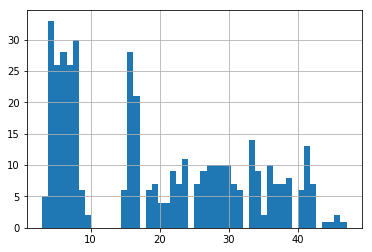

In [237]:
result.total_cases.hist(bins = 50)

In [238]:
print ("cv error:", mean_absolute_error(train_labels.total_cases, train_result.total_cases))

cv error: 7.674450549450549


In [239]:
result.to_csv('output_day4_lag.csv', index=False)

#### Woo! I scored 25.6851 on 'DengAI: Predicting Disease Spread'!